In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import nawrapper.power as nw
import nawrapper.maputils as maputils

import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

Let's generate a random map to try doing analysis on.

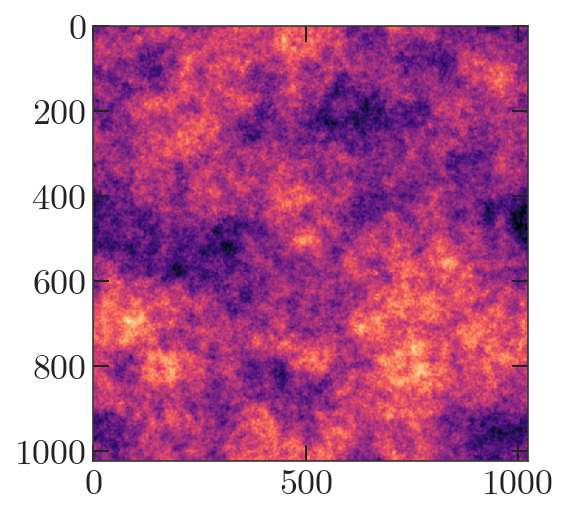

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),
                           res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[2:] = 1/ells[2:]**2.5 # don't want monopole/dipole
imap = enmap.rand_map(shape,wcs,ps[np.newaxis,np.newaxis])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

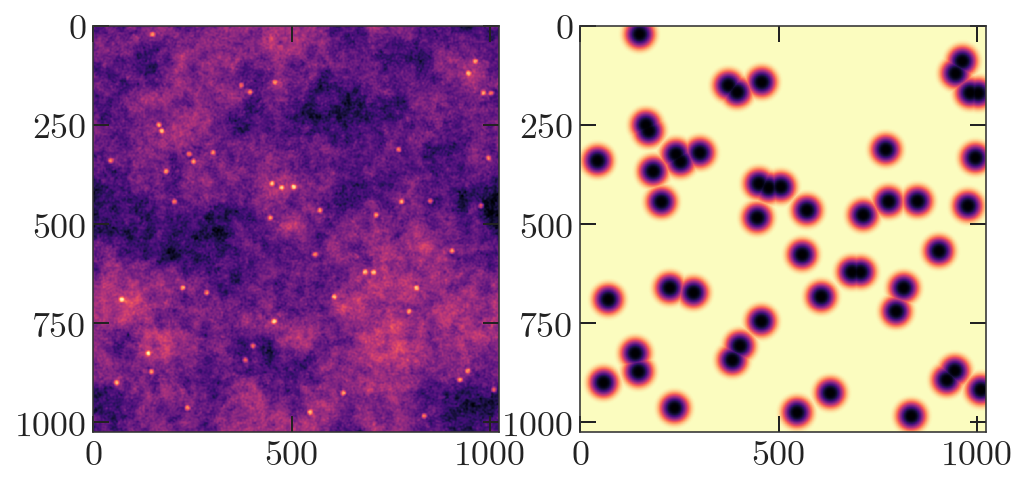

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-maputils.apod_C2(mask, 0.1)
imap += point_source_map
mask = maputils.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8,16))

axes[0].imshow(imap)
axes[1].imshow(mask)

Now let's do two noise realizations.

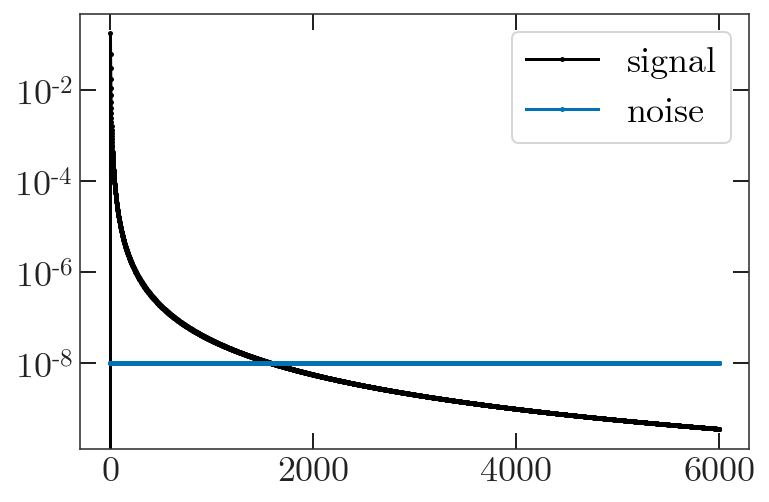

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8
plt.plot(ps, label="signal")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()

In [6]:
noise_map_1 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])
noise_map_2 = enmap.rand_map(shape, wcs,
                             nl[np.newaxis, np.newaxis])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask=mask)

Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([4.51273634e-05, 6.50483012e-06, 3.89276364e-06, 1.46284412e-06,
       6.25578242e-07, 7.39071783e-07, 5.00546110e-07, 1.89938110e-07,
       2.58781461e-07, 1.24716128e-07, 1.40395629e-07, 1.41550853e-07,
       7.99714451e-08, 3.36706032e-08, 1.06714609e-07, 5.21387215e-08,
       5.05800642e-08, 3.94148389e-08, 3.95820003e-08, 3.04237129e-08,
       2.80922567e-08, 1.92695423e-08, 2.36246451e-08, 2.07992579e-08,
       1.29901333e-08, 1.55553807e-08, 1.70811529e-08, 1.34316316e-08,
       1.43113251e-08, 9.13960612e-09, 1.12218582e-08, 1.08242121e-08,
       7.87146112e-09, 9.18426334e-09, 7.15877785e-09, 8.83082657e-09,
       5.81725398e-09, 7.43312441e-09, 6.04732940e-09, 3.52182769e-09,
       6.18222901e-09, 3.06395411e-09, 4.50766882e-09, 4.16291893e-09,
       2.62937599e-09, 2.61490398e-09, 2.15494978e-09, 2.66688152e-09,
       1.74844923e-09, 1.15836605e-09, 1.16411718e-09, 1.11308058e-09,
       2.64954945e-10, 3.00252002e-10, 3.62917254e-10, 1.62130711e-10]

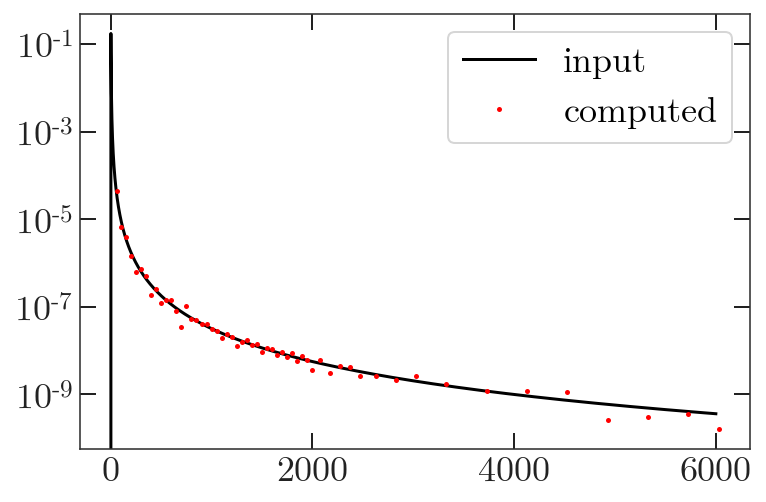

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')